In [32]:
"""
Inviscid Burgers Equation: Conservative Form
    Spatial: WENO-5 Flux splitter with FVM!!
    Temporal: RK3
"""
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import numpy.linalg
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)


In [33]:
def InitialCondition(x):
    return np.sin(2*np.pi*x)

In [34]:
def BoundaryConditionPer(u):
    u[-3:] = u[3:6]
    u[:3] = u[-6:-3]

In [35]:
def WENOSmoothCoeffL(v1,v2,v3,v4,v5):
    eps = 1e-6
    dL = np.array([0.2, 0.5, 0.3])[:,np.newaxis]
    b = np.array([
        (13.0/12.0)*(v1-2.0*v2+v3)**2 + 0.25*(v1-4.0*v2+3.0*v3)**2,
        (13.0/12.0)*(v2-2.0*v3+v4)**2 + 0.25*(v2-v4)**2,
        (13.0/12.0)*(v3-2.0*v4+v5)**2 + 0.25*(3.0*v3-4.0*v4+v5)**2
    ])
    a = dL/(b+eps)**2
    return a/np.sum(a, axis=0)

def WENOSmoothCoeffR(v1,v2,v3,v4,v5):
    eps = 1e-6
    dR = np.array([0.3, 0.5, 0.2])[:,np.newaxis]
    b = np.array([
        (13.0/12.0)*(v1-2.0*v2+v3)**2 + 0.25*(v1-4.0*v2+3.0*v3)**2,
        (13.0/12.0)*(v2-2.0*v3+v4)**2 + 0.25*(v2-v4)**2,
        (13.0/12.0)*(v3-2.0*v4+v5)**2 + 0.25*(3.0*v3-4.0*v4+v5)**2
    ])
    a = dR/(b+eps)**2
    return a/np.sum(a, axis=0)

In [36]:
def WENOfromLeft(v1,v2,v3,v4,v5):
    # if the flow come from left
    # the velocity value at i+1/2
    # i-2, i-1, i | i+1, i+2
    wL = WENOSmoothCoeffL(v1,v2,v3,v4,v5)
    uL = (
        wL[0,:]*(v1/3.0 - 7.0/6.0*v2 + 11.0/6.0*v3) +
        wL[1,:]*(-v2/6.0 + 5.0/6.0*v3 + v4/3.0) +
        wL[2,:]*(v3/3.0 + 5.0/6.0*v4 - v5/6.0)
    )
    return uL

def WENOfromRight(v1,v2,v3,v4,v5):
    # if the flow come from left
    # the velocity value at i-1/2
    # i-2, i-1 | i , i+1, i+2
    wR = WENOSmoothCoeffR(v1,v2,v3,v4,v5)
    uR = (
        wR[0,:]*(-1.0/6.0*v1 + 5.0/6.0*v2 + 1.0/3.0*v3) +
        wR[1,:]*(v2/3.0 + 5.0/6.0*v3 - v4/6.0) +
        wR[2,:]*(11.0*v3/6.0 - 7.0/6.0*v4 +1.0/3.0*v5)
    )
    return uR

In [37]:
def fluxSplitter(u, BCFun):
    f = u*np.nan
    fPlus = f+1
    fMinu = f+1

    alpha = np.amax(np.abs(np.vstack([
        u[1:-5], u[2:-4], u[3:-3], u[4:-2], u[5:-1]
    ])), axis=0)

    f[3:-3] = u[3:-3]**2/2
    fPlus[3:-3] = 0.5*(f[3:-3]+alpha*u[3:-3])
    fMinu[3:-3] = f[3:-3]-fPlus[3:-3]
    
    BCFun(fPlus)
    BCFun(fMinu)

    return fPlus, fMinu

In [38]:
def RK3WENOFluxSplitter(uOrig, dX, dT, BCfun):
    # NOTE: the journal is incorrect please have a look on
    # Proposition 3.2 in TOTAL VARIATION DIMINISHING RUNGE-KUTTA SCHEMES
    uOne = uOrig*np.nan
    uTwo = uOrig*np.nan
    uNow = uOrig*np.nan
    # First Intermediate
    fPlus, fMinu = fluxSplitter(uOrig, BoundaryConditionPer)
    fL = WENOfromLeft(fPlus[0:-5], fPlus[1:-4], fPlus[2:-3], fPlus[3:-2], fPlus[4:-1])
    fR = WENOfromRight(fMinu[1:-4], fMinu[2:-3], fMinu[3:-2], fMinu[4:-1], fMinu[5:])
    uOne[3:-3] = uOrig[3:-3] - dT/dX * (
        fL[1:] + fR[1:] - fL[:-1] - fR[:-1]
    )
    BCfun(uOne)

    # Second Intermediate
    fPlus, fMinu = fluxSplitter(uOne, BoundaryConditionPer)
    fL = WENOfromLeft(fPlus[0:-5], fPlus[1:-4], fPlus[2:-3], fPlus[3:-2], fPlus[4:-1])
    fR = WENOfromRight(fMinu[1:-4], fMinu[2:-3], fMinu[3:-2], fMinu[4:-1], fMinu[5:])
    uTwo[3:-3] = 3./4. * uOrig[3:-3] + 1./4. * uOne[3:-3] - 0.25 * dT/dX * (
        fL[1:] + fR[1:] - fL[:-1] - fR[:-1]
    )
    BCfun(uTwo)

    # Final
    fPlus, fMinu = fluxSplitter(uTwo, BoundaryConditionPer)
    fL = WENOfromLeft(fPlus[0:-5], fPlus[1:-4], fPlus[2:-3], fPlus[3:-2], fPlus[4:-1])
    fR = WENOfromRight(fMinu[1:-4], fMinu[2:-3], fMinu[3:-2], fMinu[4:-1], fMinu[5:])
    uNow[3:-3] = 1./3. * uOrig[3:-3] + 2./3. * uTwo[3:-3] - 2.0/3.0 * dT/dX * (
        fL[1:] + fR[1:] - fL[:-1] - fR[:-1]
    )
    BCfun(uNow)
    return uNow

The Rusanov flux should be
$$
f_{i+\frac{1}{2}} = \frac{1}{2}(f^L_{i+\frac{1}{2}}+f^R_{i+\frac{1}{2}}) - \frac{c_{i+\frac{1}{2}}}{2}(u^{\textcolor{red}{R}}_{i+\frac{1}{2}}-u^{\textcolor{red}{L}}_{i+\frac{1}{2}})
$$

In [39]:
def RusanovFlux(u, BCFun):
    fPlus, fMinu = fluxSplitter(u, BCFun)
    uL = WENOfromLeft(u[0:-5], u[1:-4], u[2:-3], u[3:-2], u[4:-1])
    uR = WENOfromRight(u[1:-4], u[2:-3], u[3:-2], u[4:-1], u[5:])
    fL = uL**2/2
    fR = uR**2/2
    return 0.5*(fL+fR) - 0.5*np.maximum(np.abs(u[2:-3]), np.abs(u[3:-2]))*(uR-uL) # here

In [40]:
def RK3WENORiemannRusanov(uOrig, dX, dT, BCfun):
    # NOTE: the journal is incorrect please have a look on
    # Proposition 3.2 in TOTAL VARIATION DIMINISHING RUNGE-KUTTA SCHEMES
    uOne = uOrig*np.nan
    uTwo = uOrig*np.nan
    uNow = uOrig*np.nan
    # First Intermediate
    fRusanov = RusanovFlux(uOrig, BoundaryConditionPer)
    uOne[3:-3] = uOrig[3:-3] - dT/dX * (
        fRusanov[1:] - fRusanov[:-1]
    )
    BCfun(uOne)

    # Second Intermediate
    fRusanov = RusanovFlux(uOne, BoundaryConditionPer)
    uTwo[3:-3] = 3./4. * uOrig[3:-3] + 1./4. * uOne[3:-3] - 0.25 * dT/dX * (
        fRusanov[1:] - fRusanov[:-1]
    )
    BCfun(uTwo)

    # Final
    fRusanov = RusanovFlux(uTwo, BoundaryConditionPer)
    uNow[3:-3] = 1./3. * uOrig[3:-3] + 2./3. * uTwo[3:-3] - 2.0/3.0 * dT/dX * (
        fRusanov[1:] - fRusanov[:-1]
    )
    BCfun(uNow)
    return uNow

In [41]:
# Domain   0...1
xMin, xMax = (0., 1.)
numCell = 200
xNode = np.linspace(xMin, xMax, num=numCell+1)
xCen = (xNode[:-1]+xNode[1:])/2
deltaX = xCen[1] - xCen[0]
xCwG = np.array([
    *(xCen[0:3]-3*deltaX), *xCen,*(xCen[-3:]+3*deltaX)
])

# temporal
tStart = 0.0
tEnd = 0.25
deltaT = 1e-4

# how many state to save (w/o initial condition)
numSaveState = 10
timeState = np.linspace(tStart,tEnd,numSaveState+1,endpoint=True)
States = np.zeros((numSaveState+1, xCwG.shape[0]))*np.nan


In [42]:
uInitial = InitialCondition(xCwG)
BoundaryConditionPer(uInitial)

uOriginal = uInitial*1.0
States[0, :] = uOriginal

tNow = tStart

In [43]:

while (tNow < tEnd-deltaT*0.01):
    tNow += deltaT
    uOriginal = RK3WENORiemannRusanov(uOriginal, deltaX, deltaT, BoundaryConditionPer)
    
    if np.min(np.abs(tNow-timeState)) < deltaT*0.2:
        States[np.argmin(np.abs(tNow-timeState)), :] = uOriginal

Text(0.5, 1.0, 'Time Evolution of Values')

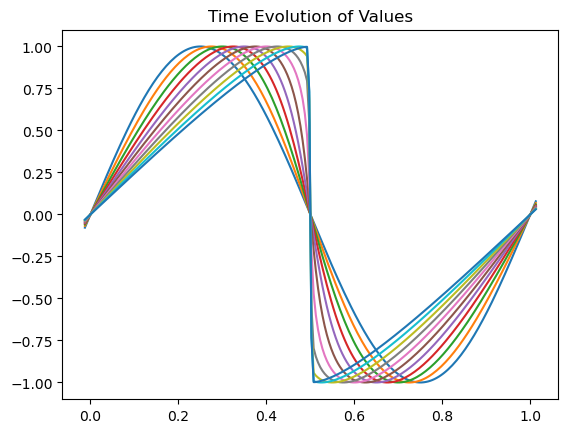

In [44]:
fig, ax = plt.subplots()
for i in range(numSaveState+1):
    ax.plot(xCwG, States[i,:], linestyle="-")  
ax.set_ylim([-1.1,1.1])
ax.set_title("Time Evolution of Values")